**Dataset: https://github.com/Franck-Dernoncourt/pubmed-rct** 

**Research Paper: https://arxiv.org/pdf/1710.06071.pdf**

# Import Libraries and Dataset

In [1]:
# Import required lbraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# Clone the GitHub repository containing the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.08 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check the contents of the directory
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Set the data directory path
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
# Get the list of file paths in the data directory
import os

filenames = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Preprocess Data

In [6]:
def get_lines(filename):
  """
  Reads the contents of a file and returns a list of strings, where each string represents a line of text from the file.

  Args:
    filename (str): The name of the file to read.

  Returns:
    list: A list of strings, where each string represents a line of text from the file.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Read the lines of the training data file
train_lines = get_lines("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
train_lines[:30], len(train_lines)

(['###24293578\n',
  'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
  'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) -

In [8]:
def preprocess_text(filename):
  """
  Preprocesses text data from a file and returns a list of dictionaries, where each dictionary represents a sample of the preprocessed data.

  Args:
    filename (str): The name of the file containing the text data.

  Returns:
    list: A list of dictionaries, where each dictionary represents a sample of the preprocessed data.
  """

  input_lines = get_lines(filename)
  abstract_lines = "" 
  abstract_samples = [] 
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): 
      abstract_id = line
      abstract_lines = "" 
    elif line.isspace(): 
      abstract_line_split = abstract_lines.splitlines() 

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} 
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower() 
        line_data["line_number"] = abstract_line_number 
        line_data["total_lines"] = len(abstract_line_split) - 1 
        abstract_samples.append(line_data) 
    
    else: 
      abstract_lines += line
  
  return abstract_samples

In [9]:
# Preprocess the training, validation, and test data files
train_samples = preprocess_text("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
val_samples = preprocess_text("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt")
test_samples = preprocess_text("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt")

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
# Create DataFrames for the training, validation, and test data
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [12]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

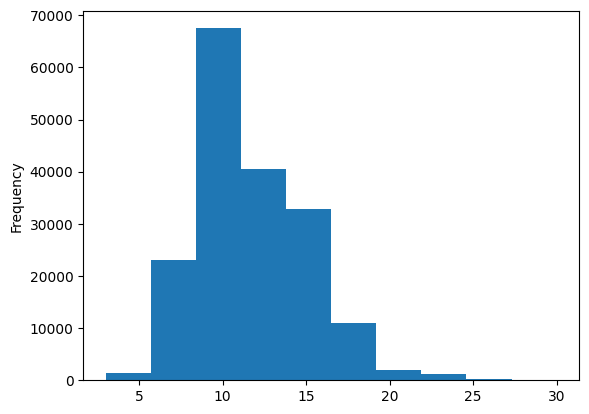

In [13]:
train_df["total_lines"].plot.hist();

In [14]:
# Get the list of sentences from the DataFrames
train_sentences = train_df['text'].tolist()
test_sentences = test_df['text'].tolist()
val_sentences = val_df['text'].tolist()

In [15]:
# Make Numeric Labels (Label ENcoding)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'])
test_labels_encoded = label_encoder.transform(test_df['target'])
val_labels_encoded = label_encoder.transform(val_df['target'])


In [16]:
# Get class names from Label Encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [17]:
# Function to evaluate: Accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall, f1 score of a binary classification model
  """

  # calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # calcualte model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}

  return model_results

## Preparing Text Data for Deep Sequence Models

**Before building deep models, we need to create vectorization and embedding layers.**

In [18]:
# How long is each sentence on average?
sentence_lens = [len(sentence.split()) for sentence in train_sentences]
sentence_lens[:10]

[49, 27, 15, 14, 35, 29, 30, 55, 36, 8]

In [19]:
avg_sent_lens = int(np.mean(sentence_lens))
avg_sent_lens

26

In [20]:
# Create a sentence tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_mode="int",
                                    output_sequence_length=55)

In [21]:
# Adapt text vectorizer in training sentences
text_vectorizer.adapt(train_sentences)

In [22]:
# Test text vectorizer on random sentence
import random
random_sentence = random.choice(train_sentences)
print(f"""
Random Text: {random_sentence}
Length of Text: {len(random_sentence.split())}
Vectorized Text: {text_vectorizer([random_sentence])}
Shape of Vectorizes Text: {text_vectorizer([random_sentence]).shape}
""")


Random Text: the venturi mask ( n = @ ) or nhf ( n = @ ) were applied for @ hours postextubation .
Length of Text: 22
Vectorized Text: [[    2 19323  2184    40    16 11966    40     9   551    11   227 19865
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Shape of Vectorizes Text: (1, 55)



In [23]:
# How many words in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"""
Number of Words in the Vocabulary: {len(rct_20k_text_vocab)}
Most Common Words in the Vocabulary: {rct_20k_text_vocab[:5]}
Least Common Words in the Vocabulary: {rct_20k_text_vocab[-5:]}
""")


Number of Words in the Vocabulary: 64841
Most Common Words in the Vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least Common Words in the Vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']



In [24]:
# Get config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [25]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, mask_zero=True,
                               name='Embeddin_Layer')

In [26]:
# Show example embedding 
vectorized_sentence = text_vectorizer([random_sentence])
embedded_sentence = token_embed(vectorized_sentence)
print(f"""
Sentence: {random_sentence}
Tokenized Sentence: {vectorized_sentence}
Embedded Sentence: {embedded_sentence}
Embedded Sentence Shape: {embedded_sentence.shape}
""")


Sentence: the venturi mask ( n = @ ) or nhf ( n = @ ) were applied for @ hours postextubation .
Tokenized Sentence: [[    2 19323  2184    40    16 11966    40     9   551    11   227 19865
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Embedded Sentence: [[[ 0.02360487  0.03061305  0.04002119 ...  0.00431706 -0.02185439
   -0.00830289]
  [-0.03743397  0.00721824 -0.02732226 ...  0.0180229   0.0412438
   -0.03295062]
  [-0.00370263 -0.02726324  0.00254796 ...  0.01994478 -0.04234516
   -0.00806849]
  ...
  [ 0.00499598  0.01739084 -0.02710276 ... -0.0205622  -0.01280804
    0.0145405 ]
  [ 0.00499598  0.01739084 -0.02710276 ... -0.0205622  -0.01280804
    0.0145405 ]
  [ 0.00499598  0.01739084 -0.02710276 ... -0.0205622  -0.01280804
    0.0145405 ]]]
Embedded Sentence

## Creating Neural Network Friendly Datasets

In [27]:
# Create TensorFlow datasets from the tensor slices
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_encoded))

In [28]:
# Batch and prefetch datasets
train_dataset = train_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [29]:
# Downlaod pretrained Tensorflow Hub Universal Sentence Encoder
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False, 
                                        name='universal_sentence_encoder')

In [30]:
# Test our pretrained embedding on a random sentence
random_sentence = random.choice(train_sentences)
print(f"""
Random Sentence: {random_sentence}
Embedded Sentence: {tf_hub_embedding_layer([random_sentence])[0][:30]}
Shape of Embedded Sentence: {tf_hub_embedding_layer([random_sentence]).shape}
""")


Random Sentence: patients underwent neurological examinations , along with cognitive and neuropsychological testing ( fab , mmse , hads and other tests ) .
Embedded Sentence: [-0.06644048  0.01305442 -0.03188183 -0.06765658 -0.02623685  0.00477206
 -0.00638677 -0.04389182 -0.07211418 -0.01952425  0.08341594  0.03124146
  0.0713385   0.06911519 -0.0122525  -0.03729893 -0.08427159  0.03095698
  0.06592571 -0.00688899  0.06872479  0.05669319 -0.0729154   0.04452721
  0.02234741  0.02858562  0.01792669  0.04544632 -0.00084962 -0.00187179]
Shape of Embedded Sentence: (1, 512)



## Creating a Character Level Tokenizer

In [31]:
# Create funciton to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [32]:
print(f"""
{split_chars(random_sentence)}
{split_chars(random_sentence)[:10]}
""")


p a t i e n t s   u n d e r w e n t   n e u r o l o g i c a l   e x a m i n a t i o n s   ,   a l o n g   w i t h   c o g n i t i v e   a n d   n e u r o p s y c h o l o g i c a l   t e s t i n g   (   f a b   ,   m m s e   ,   h a d s   a n d   o t h e r   t e s t s   )   .
p a t i e 



In [33]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [34]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [35]:
# How long of a sentence covers 95% of the lengths?
seq_char_len = np.percentile(char_lens, 95)
seq_char_len

290.0

In [36]:
# All keyboard characters
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [37]:
# Create a character level Tokenizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=int(seq_char_len),
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [38]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"""
Number of different characters in character vocab: {len(char_vocab)}
5 most common characters: {char_vocab[:5]}
5 least common characters: {char_vocab[-5:]}
""")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']



In [39]:
# Apply character vectorizer on random text
random_train_chars = random.choice(train_chars)
vectorized_chars = char_vectorizer([random_train_chars])
print(f"""
Charified text:\n{random_train_chars}
Length of chars: {len(random_train_chars.split())}
Vectorized chars:\n{vectorized_chars}
Length of vectorized chars: {len(vectorized_chars[0])}
""")



Charified text:
a l t h o u g h   t h i s   p r o g r a m   w a s   f e a s i b l e   ,   m o s t   s c h o o l s   a r e   u n d e r   t i m e   a n d   r e s o u r c e   p r e s s u r e   ,   t h u s   a l t e r n a t i v e   m e t h o d s   o f   d e l i v e r y   s h o u l d   b e   a s s e s s e d   f o r   f e a s i b i l i t y   a n d   e f f i c a c y   .
Length of chars: 148
Vectorized chars:
[[ 5 12  3 13  7 16 18 13  3 13  4  9 14  8  7 18  8  5 15 20  5  9 17  2
   5  9  4 22 12  2 15  7  9  3  9 11 13  7  7 12  9  5  8  2 16  6 10  2
   8  3  4 15  2  5  6 10  8  2  9  7 16  8 11  2 14  8  2  9  9 16  8  2
   3 13 16  9  5 12  3  2  8  6  5  3  4 21  2 15  2  3 13  7 10  9  7 17
  10  2 12  4 21  2  8 19  9 13  7 16 12 10 22  2  5  9  9  2  9  9  2 10
  17  7  8 17  2  5  9  4 22  4 12  4  3 19  5  6 10  2 17 17  4 11  5 11
  19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  

In [40]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, 
                              output_dim=25, 
                              mask_zero=False, 
                              name="char_embed")

In [41]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Encoding Categorical Features 

In [42]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [43]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

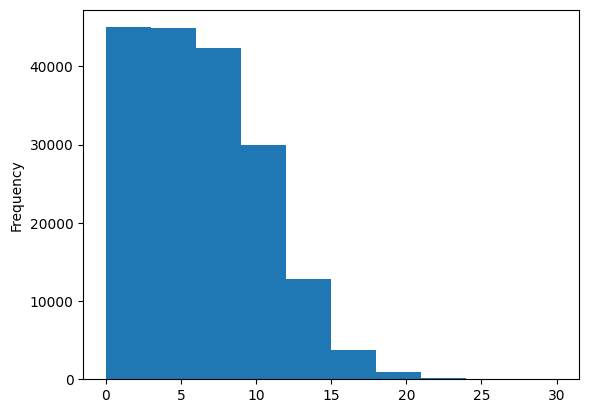

In [44]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [45]:
# Apply one-hot encoding to "line_number" 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [46]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [47]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

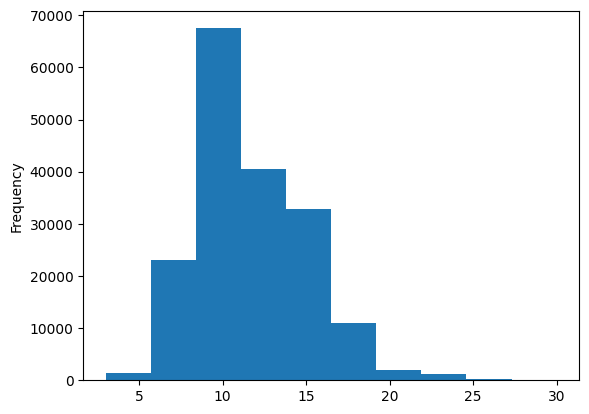

In [48]:
# Chekc the distribution of total_lines
train_df.total_lines.plot.hist();

In [49]:
np.percentile(train_df.total_lines, 98)

20.0

In [50]:
# Apply one_hot encoding to "total_lines"
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

# Model Creation

In [51]:
# Text model (Transfer Learning)
text_inputs = layers.Input(shape=[], dtype="string", name="text_inputs")
text_embeddings = tf_hub_embedding_layer(text_inputs)
text_outputs = layers.Dense(128, activation="relu")(text_embeddings)
text_model = tf.keras.Model(inputs=text_inputs,
                             outputs=text_outputs)

# Character Token Embedding
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Line Number Inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# Total Lines Inputs
total_lines_input = layers.Input(shape=(20,), dtype=tf.float32)
y = layers.Dense(32, activation='relu')(total_lines_input)
total_line_model = tf.keras.Model(total_lines_input, y)

# Combine Text and Character Embeddings
combined_embeddings = layers.Concatenate(name="text_char_hybrid_embedding")([text_model.output, 
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Combine positional embeddings with combined token and char embeddings
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])
# Output Layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)


In [52]:
# Create the model
model = tf.keras.Model(inputs=[line_number_model.input,
                               total_line_model.input,
                               text_model.input,
                               char_model.input], outputs=output_layer)

In [53]:
# Get a summary of the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 text_inputs (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['text_inputs[0][0]']      

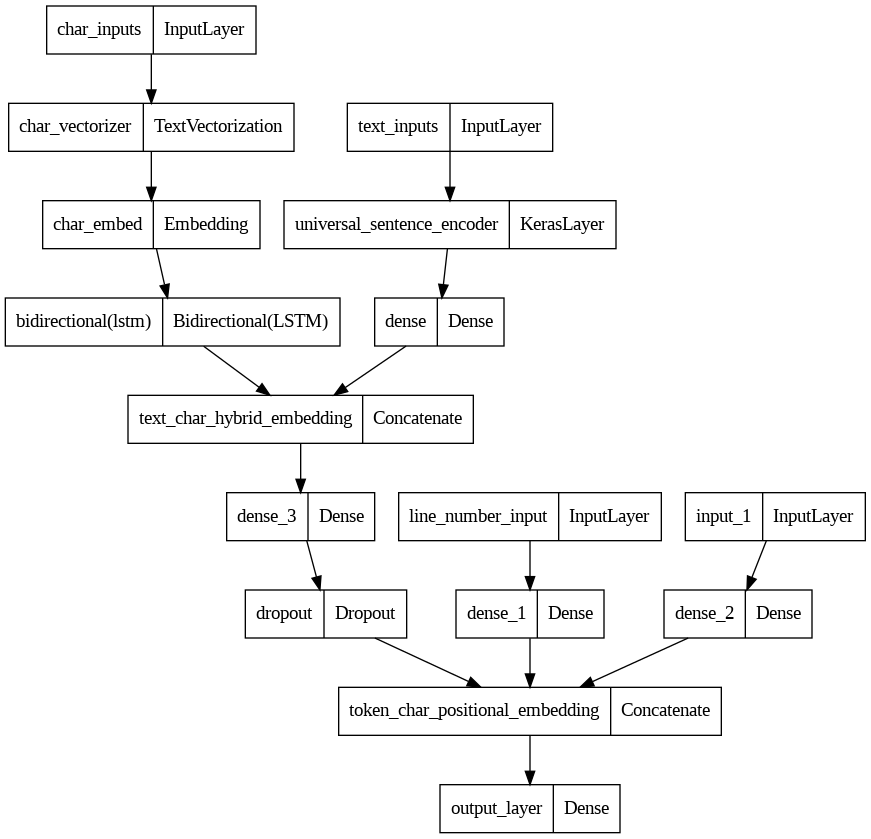

In [54]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [55]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [56]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [57]:
# Train model
history = model.fit(train_pos_char_token_dataset,
                    steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                    epochs=3,
                    validation_data=val_pos_char_token_dataset,
                    validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 172s 278ms/step - loss: 0.7733 - accuracy: 0.7072 - val_loss: 0.5461 - val_accuracy: 0.7975
Epoch 2/3
562/562 [==============================] - 152s 270ms/step - loss: 0.5049 - accuracy: 0.8097 - val_loss: 0.4722 - val_accuracy: 0.8248
Epoch 3/3
562/562 [==============================] - 158s 282ms/step - loss: 0.4660 - accuracy: 0.8156 - val_loss: 0.4491 - val_accuracy: 0.8268


In [58]:
# Get prediction probabilities
model_pred_probs = model.predict(val_pos_char_token_dataset, verbose=1)
model_pred_probs

945/945 [==============================] - 61s 63ms/step


array([[5.8262980e-01, 1.6283531e-02, 1.6750964e-04, 4.0068457e-01,
        2.3446683e-04],
       [6.6483885e-01, 7.5897076e-03, 9.1518223e-04, 3.2660389e-01,
        5.2556574e-05],
       [4.2981905e-01, 1.2982132e-02, 6.4833172e-02, 4.7885773e-01,
        1.3507850e-02],
       ...,
       [1.4918594e-04, 1.5416055e-02, 9.6874563e-03, 1.2688074e-05,
        9.7473460e-01],
       [7.5410010e-04, 1.9011702e-01, 2.1598157e-02, 6.2879051e-05,
        7.8746784e-01],
       [2.5606850e-01, 7.0388573e-01, 2.3075555e-02, 2.0297761e-03,
        1.4940474e-02]], dtype=float32)

In [59]:
# Get predictions
model_preds = tf.argmax(model_pred_probs, axis=1)
model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [60]:
# Check out model results
model_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_preds)
model_results

{'accuracy': 82.72540712299748,
 'precision': 0.8277873659912472,
 'recall': 0.8272540712299749,
 'f1': 0.8271640922072361}

In [61]:
# Save model
# model.save("/content/drive/MyDrive/Projects/skimlit_NLP/skimlit_model")

In [62]:
# Create test dataset
test_pos_char_text_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_pos_char_text_labels = tf.data.Dataset.from_tensor_slices(test_labels_encoded)
test_pos_char_text_dataset = tf.data.Dataset.zip((test_pos_char_text_data, test_pos_char_text_labels))
test_pos_char_text_dataset = test_pos_char_text_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [63]:
# Make predictions on unseen data
test_pred_probs = model.predict(test_pos_char_text_dataset,
                                  verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 74s 78ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0])>

In [64]:
# Evaluate loaded model test predictions
model_test_results = calculate_results(y_true=test_labels_encoded,
                                       y_pred=test_preds)
model_test_results

{'accuracy': 82.3560643769703,
 'precision': 0.8236007740383146,
 'recall': 0.823560643769703,
 'f1': 0.8233087576251074}

In [65]:
# Get predicted classes
test_pred_classes = [label_encoder.classes_[preds] for preds in test_preds]
test_pred_classes[:10]

['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

In [66]:
test_df['prediction'] = test_pred_classes
test_df["pred_prob"] = [np.max(arr) for arr in test_pred_probs]
test_df["correct"] = test_df["prediction"] == test_df["target"] 
test_df.head()

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.626296,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.467633,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.968582,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.747538,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.864708,True


In [67]:
# Find the most wrong predictions
top_20_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:20]
top_20_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.998972,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.997867,False
4593,METHODS,this study provides class ii evidence that reg...,11,11,CONCLUSIONS,0.994726,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.994312,False
15387,RESULTS,mechanistic analysis suggests a possible off-t...,9,10,CONCLUSIONS,0.993656,False
23305,CONCLUSIONS,the c/s rate was higher in groups c and d ; ho...,10,11,RESULTS,0.993561,False
18901,METHODS,this study provides class i evidence that for ...,11,11,CONCLUSIONS,0.993060,False
12456,RESULTS,icd patients were randomized @:@ to automatic ...,1,13,METHODS,0.993039,False
9468,CONCLUSIONS,pdt was associated with a significant decrease...,7,9,RESULTS,0.992095,False
16633,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,19,19,BACKGROUND,0.992070,False


# Test the Model on Real Life Example

In [68]:
# Test model on real life RCT Abstract

rct_example = "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group."


In [69]:
# Extract sentences from Abstract paragraph
from spacy.lang.en import English

nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe("sentencizer")
doc = nlp(rct_example)
lines = [str(sent) for sent in list(doc.sents)]
lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [70]:
total_sample_lines = len(lines)

In [71]:
# Get data ready for model
sample_lines = []
for i, line in enumerate(lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_sample_lines - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [72]:
test_line_numbers = [line["line_number"] for line in sample_lines]

# One-hot encode to same depth as training data, so model accepts right input shape
test_line_numbers_one_hot = tf.one_hot(test_line_numbers, depth=15) 
test_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [73]:
test_total_lines = [line["total_lines"] for line in sample_lines]

# One-hot encode to same depth as training data, so model accepts right input shape
test_total_lines_one_hot = tf.one_hot(test_total_lines, depth=20)
test_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [74]:
chars = [split_chars(sentence) for sentence in lines]
chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [75]:
# Make predicitons with example
test_abstract_pred_probs = model.predict(x=(test_line_numbers_one_hot,
                                            test_total_lines_one_hot,
                                            tf.constant(lines),
                                            tf.constant(chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step


array([[2.81824917e-01, 6.98582130e-03, 5.98297629e-04, 7.10411370e-01,
        1.79498951e-04],
       [1.99301820e-03, 5.04174677e-05, 9.84116375e-01, 1.79917889e-03,
        1.20409774e-02],
       [1.13890342e-01, 9.52137925e-04, 5.94252586e-01, 2.79842019e-01,
        1.10630123e-02],
       [8.66076648e-02, 2.48561483e-02, 7.54064202e-01, 4.40521613e-02,
        9.04199407e-02],
       [1.99780185e-02, 1.28545137e-02, 7.38939703e-01, 9.87635367e-03,
        2.18351454e-01],
       [8.27005599e-03, 1.66466981e-02, 7.62932658e-01, 4.82113985e-03,
        2.07329497e-01],
       [1.65202736e-03, 1.00493364e-01, 3.64485122e-02, 2.76444247e-04,
        8.61129582e-01],
       [8.26634059e-04, 2.38914993e-02, 3.80539984e-01, 7.25684862e-04,
        5.94016075e-01]], dtype=float32)

In [76]:
# Get predictions
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [77]:
# Show predicted classes
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [78]:
result_df = pd.DataFrame({'Predictions':test_abstract_pred_classes, 'Lines':lines})
result_df

,Predictions,Lines
0,OBJECTIVE,This RCT examined the efficacy of a manualized...
1,METHODS,Participants were randomly assigned to treatme...
2,METHODS,Treatment included instruction and therapeutic...
3,METHODS,A response-cost program was applied to reduce ...
4,METHODS,Significant treatment effects were found for f...
5,METHODS,Secondary measures based on staff ratings (tre...
6,RESULTS,"High levels of parent, child and staff satisfa..."
7,RESULTS,Standardized effect size estimates were primar...
